In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as smi
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from statistics import mean
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, SimpleRNN, GRU, Dropout, Conv1D, MaxPooling1D, Flatten, RepeatVector
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error, mean_absolute_error
from tensorflow.keras.optimizers import Adam, Nadam, RMSprop
from statsmodels.tsa.seasonal import seasonal_decompose
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from hyperopt import hp, Trials, fmin, tpe
import joblib
import warnings
warnings.simplefilter('ignore')

In [2]:
df=pd.read_csv(r'E:\A aPython Programms\Data1\Bank.csv')
df.head(5)

,Date,AXISBANK,AXISVOL,BAJAJFIN,BAJAJFINVOL,BOB,BOBVOL,FEDBANK,FEDVOL,HDFC,...,KOTAK,KOTAKVOL,PNB,PNBVOL,SBI,SBIVOL,REC,RECVOL,PIRAMAL,PIRAMALVOL
0,02-01-2009,108.379997,14261265,6.310420,141738,57.340000,1700495,16.889999,1359910,101.565002,...,97.900002,6258884,106.430000,2973855,133.184998,24161650,29.587500,9574565,134.700485,222908
1,05-01-2009,112.019997,9165605,6.504736,1120575,58.860001,2687100,17.129999,4379460,104.410004,...,99.637497,5956956,107.160004,3037185,136.080002,26931910,30.562500,8844514,136.025497,14449
2,06-01-2009,113.949997,12893855,6.660189,312830,57.750000,3162520,16.760000,1930260,110.040001,...,96.712502,9015300,106.089996,4110100,132.285004,35970960,29.831249,1078005,133.516418,102783
3,07-01-2009,104.419998,10571555,6.150109,166223,54.939999,5602350,16.459999,2251090,100.925003,...,90.762497,6482408,97.660004,6538860,124.004997,37268580,28.424999,5624090,131.853104,24863
4,09-01-2009,97.320000,25173105,6.048093,95905,54.689999,1806325,16.004999,4046570,101.750000,...,86.125000,5076276,97.129997,3834090,122.110001,24996510,28.818750,6157634,129.654144,301873


In [3]:
feature_columns = ['BAJAJFIN', 'BAJAJFINVOL', 'ICICI', 'SBI', 'FEDBANK']
target_column = ['BAJAJFIN']
features = df[feature_columns]
target = df[target_column].shift(-2)

new_data1 = 7250.95
target.iloc[-2, 0] = new_data1

new_data2 = 7207.40
target.iloc[-1, 0] = new_data2
target.tail(5)


,BAJAJFIN
3748,6910.100098
3749,7022.750000
3750,7245.250000
3751,7250.950000
3752,7207.400000


In [4]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)
scaled_target = scaler.fit_transform(target.values.reshape(-1, 1))
target=target.dropna()

n_steps = 5 # Number of timesteps to look back
X, y = [], []

for i in range(n_steps, len(scaled_features)):
    X.append(scaled_features[i-n_steps:i])
    y.append(scaled_target[i])

X = np.array(X)
y = np.array(y)

split=int(0.8*len(X))
X_train, y_train= X[:split], y[:split]
X_test, y_test= X[split:], y[split:]

In [5]:
model_lstm = load_model('model_lstm_bajajfin2h_0.9139.keras')
model_lstm.predict(X_test)

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_test, predictions_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R2: 0.9139
MAPE: 0.0243
RMSE: 218.5354
RMSE_normalizeddata: 0.0268
MAE_normalizeddata: 0.0200
MAE: 162.9357


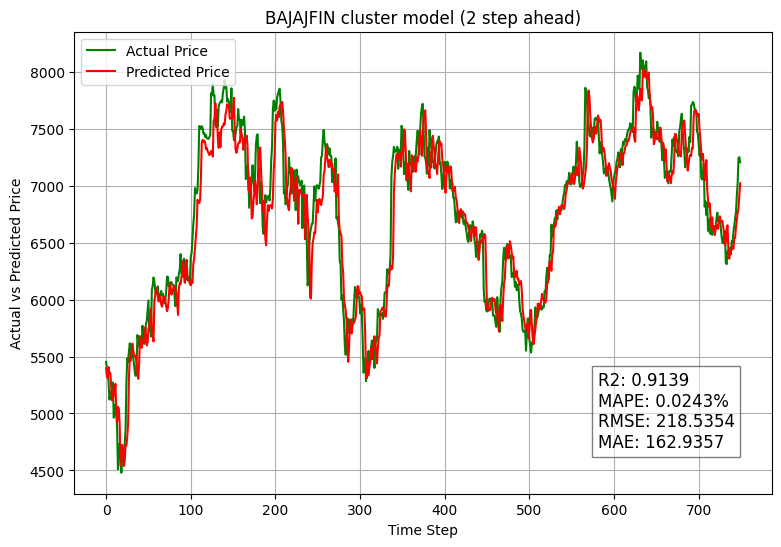

In [6]:
plt.figure(figsize=(9, 6))
plt.plot(y_test_actual_LSTM, color='green', label=['Actual Price'])
plt.plot(predictions_LSTM, color='red', label=['Predicted Price'])
plt.legend(['Actual Price', 'Predicted Price'], loc='upper left')

plt.text(0.75, 0.1, f'R2: {r2:.4f}\nMAPE: {mape:.4f}%\nRMSE: {rmse:.4f}\nMAE: {mae:.4f}', 
         fontsize=12, 
         bbox=dict(facecolor='white', alpha=0.5),
         transform=plt.gca().transAxes)

plt.grid(True)
plt.title('BAJAJFIN cluster model (2 step ahead)')
plt.xlabel('Time Step')
plt.ylabel('Actual vs Predicted Price')
plt.savefig('bajajfincluster_2sa-1l.png', dpi=600)  # Saves the plot as a PNG file
plt.show()

In [7]:
model_lstm.predict(X_train)

predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
R2: 0.9966
MAPE: 0.2679
RMSE: 81.8155
RMSE_normalizeddata: 0.0100
MAE_normalizeddata: 0.0060
MAE: 48.9151


In [69]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step - loss: 0.0084 - val_loss: 0.0142
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8811e-04 - val_loss: 0.0073
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0053e-04 - val_loss: 0.0045
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8320e-04 - val_loss: 0.0037
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5568e-04 - val_loss: 0.0080
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.1733e-04 - val_loss: 0.0021
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5839e-04 - val_loss: 0.0013
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6338e-04 - val_loss: 0.0014
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5574e-04 - val_loss: 0.0011
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6223e-04 - val_loss: 0.0015
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9050e-04 - val_loss: 9.9828e

In [70]:
model_lstm.save('model_lstm_bajajfin2h_1.keras')

In [71]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.0067 - val_loss: 0.0057
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 2.0905e-04 - val_loss: 0.0047
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6865e-04 - val_loss: 0.0017
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.4881e-04 - val_loss: 0.0014
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8398e-04 - val_loss: 0.0013
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.6136e-04 - val_loss: 0.0041
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7957e-04 - val_loss: 9.9709e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.6914e-04 - val_loss: 0.0011
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.0074e-04 - val_loss: 9.9481e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.5847e-04 - val_loss: 0.0013
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3924e-04 - val_loss: 

In [72]:
model_lstm.save('model_lstm_bajajfin2h_2.keras')

In [73]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0064 - val_loss: 0.0098
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5263e-04 - val_loss: 0.0047
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7847e-04 - val_loss: 0.0022
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0766e-04 - val_loss: 0.0024
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.3058e-04 - val_loss: 0.0022
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8916e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4006e-04 - val_loss: 0.0014
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3659e-04 - val_loss: 0.0014
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6220e-04 - val_loss: 0.0012
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7327e-04 - val_loss: 0.0013
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7417e-04 - val_loss: 0.0010


In [74]:
model_lstm.save('model_lstm_bajajfin2h_3.keras')

In [75]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - loss: 0.0061 - val_loss: 0.0036
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9455e-04 - val_loss: 0.0019
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7823e-04 - val_loss: 0.0020
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8930e-04 - val_loss: 0.0024
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5266e-04 - val_loss: 0.0021
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4409e-04 - val_loss: 0.0022
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.1067e-04 - val_loss: 0.0011
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2898e-04 - val_loss: 0.0011
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7909e-04 - val_loss: 0.0021
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5288e-04 - val_loss: 9.8729e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.9281e-04 - val_loss: 0.0

In [76]:
model_lstm.save('model_lstm_bajajfin2h_4.keras')

In [77]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - loss: 0.0063 - val_loss: 0.0055
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8066e-04 - val_loss: 0.0038
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8333e-04 - val_loss: 0.0027
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8030e-04 - val_loss: 0.0018
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6613e-04 - val_loss: 0.0012
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0352e-04 - val_loss: 0.0024
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5130e-04 - val_loss: 0.0037
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.2339e-04 - val_loss: 0.0035
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.8200e-04 - val_loss: 9.5705e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3229e-04 - val_loss: 9.8835e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.3570e-04 - val_loss:

In [78]:
model_lstm.save('model_lstm_bajajfin2h_5.keras')

In [79]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - loss: 0.0059 - val_loss: 0.0056
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1846e-04 - val_loss: 0.0026
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1989e-04 - val_loss: 0.0036
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9003e-04 - val_loss: 0.0016
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8897e-04 - val_loss: 0.0018
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7987e-04 - val_loss: 0.0020
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.6305e-04 - val_loss: 0.0033
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7119e-04 - val_loss: 0.0013
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7994e-04 - val_loss: 0.0014
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8150e-04 - val_loss: 0.0013
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3860e-04 - val_loss: 0.0016


In [80]:
model_lstm.save('model_lstm_bajajfin2h_6.keras')

In [81]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0056 - val_loss: 0.0033
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.4794e-04 - val_loss: 0.0040
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.9346e-04 - val_loss: 0.0018
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7853e-04 - val_loss: 0.0013
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0132e-04 - val_loss: 0.0013
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5674e-04 - val_loss: 0.0015
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7510e-04 - val_loss: 0.0015
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7771e-04 - val_loss: 0.0020
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.5881e-04 - val_loss: 0.0011
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 1.3250e-04 - val_loss: 0.0011
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5661e-04 - val_loss: 8.6101e

In [82]:
model_lstm.save('model_lstm_bajajfin2h_7.keras')

In [83]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - loss: 0.0040 - val_loss: 0.0080
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.6817e-04 - val_loss: 0.0020
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.5871e-04 - val_loss: 0.0013
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.8197e-04 - val_loss: 0.0012
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3675e-04 - val_loss: 0.0019
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4843e-04 - val_loss: 0.0020
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.5940e-04 - val_loss: 9.9032e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3967e-04 - val_loss: 0.0013
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4497e-04 - val_loss: 9.4524e-04
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7491e-04 - val_loss: 9.9851e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.6371e-04 - val_

In [84]:
model_lstm.save('model_lstm_bajajfin2h_8.keras')

In [85]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0070 - val_loss: 0.0040
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.9737e-04 - val_loss: 0.0022
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 1.7630e-04 - val_loss: 0.0052
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - loss: 2.0298e-04 - val_loss: 0.0057
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8103e-04 - val_loss: 0.0031
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 1.3483e-04 - val_loss: 0.0013
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.7598e-04 - val_loss: 0.0014
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.3751e-04 - val_loss: 0.0111
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4594e-04 - val_loss: 0.0020
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.6214e-04 - val_loss: 0.0011
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4951e-04 - val_loss: 9.5525e

In [86]:
model_lstm.save('model_lstm_bajajfin2h_9.keras')

In [87]:
model_lstm = tf.keras.Sequential()
model_lstm.add(tf.keras.layers.LSTM(169, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
model_lstm.add(tf.keras.layers.Dense(1))
model_lstm.compile(optimizer=Nadam(learning_rate=0.00398), loss='mse')
model_lstm.fit(X_train, y_train, epochs=200, batch_size=30, validation_data=(X_test, y_test), callbacks=[EarlyStopping(monitor='loss', patience=5)])

predictions_lstm = model_lstm.predict(X_test)
predictions_LSTM = scaler.inverse_transform(predictions_lstm)
y_test_actual_LSTM = scaler.inverse_transform(y_test.reshape(-1, 1))

r2=r2_score(y_test_actual_LSTM, predictions_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_test_actual_LSTM, predictions_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_test, predictions_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae=mean_absolute_error(y_test_actual_LSTM, predictions_LSTM)
print(f"MAE: {mae:.4f}")

Epoch 1/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 0.0040 - val_loss: 0.0043
Epoch 2/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 2.0266e-04 - val_loss: 0.0021
Epoch 3/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.8042e-04 - val_loss: 0.0018
Epoch 4/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.7111e-04 - val_loss: 0.0020
Epoch 5/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4996e-04 - val_loss: 0.0015
Epoch 6/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 2.1047e-04 - val_loss: 0.0012
Epoch 7/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1.4656e-04 - val_loss: 9.4740e-04
Epoch 8/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4739e-04 - val_loss: 0.0013
Epoch 9/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.3308e-04 - val_loss: 0.0013
Epoch 10/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.4674e-04 - val_loss: 8.8710e-04
Epoch 11/200
100/100 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 1.2598e-04 - val_loss:

In [88]:
predictions_train_lstm = model_lstm.predict(X_train)
predictions_train_LSTM = scaler.inverse_transform(predictions_train_lstm)
y_train_actual_LSTM = scaler.inverse_transform(y_train.reshape(-1, 1))

r2=r2_score(y_train_actual_LSTM, predictions_train_LSTM)
print(f"R2: {r2:.4f}")

mape=mean_absolute_percentage_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAPE: {mape:.4f}")

mse=mean_squared_error(y_train_actual_LSTM, predictions_train_LSTM)
rmse=np.sqrt(mse)
print(f"RMSE: {rmse:.4f}")

mse_normalizeddata=mean_squared_error(y_train, predictions_train_lstm)
rmse_normalizeddata=np.sqrt(mse_normalizeddata)
print(f"RMSE_normalizeddata: {rmse_normalizeddata:.4f}")

mae_n=mean_absolute_error(y_train, predictions_train_lstm)
print(f"MAE_normalizeddata: {mae_n:.4f}")

mae=mean_absolute_error(y_train_actual_LSTM, predictions_train_LSTM)
print(f"MAE: {mae:.4f}")

94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
R2: 0.9962
MAPE: 0.0827
RMSE: 86.3862
RMSE_normalizeddata: 0.0106
MAE_normalizeddata: 0.0052
MAE: 42.2843


In [89]:
model_lstm.save('model_lstm_bajajfin2h_10.keras')